In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Import data prepared in previous steps (only data for 2018 survey, full time employment, and removed outliers) and used for all machine learning models. The target is hourly rate and predictors are economic sector (nace), company size (esize_class), gender, age class, profession (lpk), education. All these are categorical variables. Single numerical variable is experience in years.

In [2]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv') 
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,p721,G2,13,8.20
1,C,1_49,F,40-49,p334,G2,0,2.51
2,M,50_249,F,40-49,p522,G2,18,2.19
3,M,50_249,F,40-49,p522,G2,12,2.19
4,M,50_249,F,14-29,p522,G2,0,2.19


One fifth of records is kept for testing of models.

In [3]:
y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

print('Dataset lengths:', 'train', len(y_train), ', test', len(y_test))

Dataset lengths: train 26114 , test 6529


# Model and predictions

## Initial Support Vector Regression model

Initial Nu Support Vector Regression model used to test pipline and estimate the baseline accuracy. Numerical feature is scaled with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and categorical features are encoded using [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import NuSVR

numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocessor = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education']),
        ("numerical", numeric_preprocessor, ['experience'])
    ],
    sparse_threshold=0
)

model = Pipeline([('prep', preprocessor), ('regr', NuSVR(cache_size=5000))])
model.fit(X=X_train, y=y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr', NuSVR(cache_size=5000))])

Function to print model prediction RMSE and R2

In [5]:
def print_model_rmse_r2(model, X_train, y_train, X_test, y_test):
    """ 
    Function to print model prediction RMSE and R2
    for train and test datasets
        Parameters:
        model - model to evaluate
        X_train - train features
        y_train - train target 
        X_test - test features
        y_test - test target
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)

    r2_train = r2_score(y_train, y_train_pred).round(3)
    r2_test = r2_score(y_test, y_test_pred).round(3)

    print('Train: RMSE=', rmse_train, ' R2=', r2_train,
        '\nTest: RMSE=', rmse_test, ' R2=', r2_test)

RMSE and R2 of initial model predicions for train and test datasets.

In [6]:
print_model_rmse_r2(model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.617  R2= 0.596 
Test: RMSE= 1.659  R2= 0.573


Nu Support Vector Regression runs slow with default kernel. We tested accuracy and runtime for other kernels, but fhe model with default rbf kernel is best in terms of accuracy. Total training + testing time is longer for rbf, but not by much.

In [7]:
from time import time
kernels = ['linear', 'poly', 'rbf']

for kernel in kernels:
    model = Pipeline([('prep', preprocessor), ('regr', NuSVR(kernel=kernel, cache_size=5000))])
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_test_pred = model.predict(X_test)
    predict_time = time()-start    
    print('Kernel: ', kernel)
    print(f"Training time {train_time:.3f}s and prediction time {predict_time:.3f}s")
    print(f"Test mean squared error: {mean_squared_error(y_test, y_test_pred):.3f} and  R2: {r2_score(y_test, y_test_pred):.3f}")
    print()

Kernel:  linear
Training time 37.928s and prediction time 3.695s
Test mean squared error: 3.008 and  R2: 0.534

Kernel:  poly
Training time 38.086s and prediction time 4.724s
Test mean squared error: 2.770 and  R2: 0.571

Kernel:  rbf
Training time 37.603s and prediction time 10.483s
Test mean squared error: 2.753 and  R2: 0.573



## Grid Search CV for NuSVR

We used Grid Search cross validation to tune NuSVR model hyperparameters. C and gamma use as recommended by SVR [user guide](https://scikit-learn.org/stable/modules/svm.html#svm-regression)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
model = Pipeline([('prep', preprocessor), ('regr', NuSVR(cache_size=5000))])

grid = {
        'regr__C': np.logspace(-5,1,num=5),
        'regr__gamma' : np.logspace(-2, 0, 5)
         }
search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv)
results = search.fit(X=X_train,y=y_train)

results_pd = pd.DataFrame(results.cv_results_)
results_pd.filter(regex='rank|regr|mean_test_score|std_test_score',axis=1).sort_values('rank_test_score').head().T

,22,21,20,23,17
param_regr__C,10.0,10.0,10.0,10.0,0.316228
param_regr__gamma,0.1,0.031623,0.01,0.316228,0.1
mean_test_score,-1.673988,-1.6886,-1.74319,-1.761319,-1.802504
std_test_score,0.032375,0.035526,0.042582,0.033629,0.050133
rank_test_score,1,2,3,4,5


In [9]:
best_model=results.best_estimator_
best_model

Pipeline(steps=[('prep',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr', NuSVR(C=10.0, cache_size=5000, gamma=0.1))])

In [10]:
print_model_rmse_r2(best_model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.481  R2= 0.661 
Test: RMSE= 1.63  R2= 0.588


Four of five best iterations were with C = 10. The optimal gamma is most likely between 0.032 (2 of 5 best iterations) and 0.1 (3 of 5 best iterations). The performance gain of best model (C=10, gamma=0.1) over initial model is small, but we will use it in further analysis.  

## Feature importance

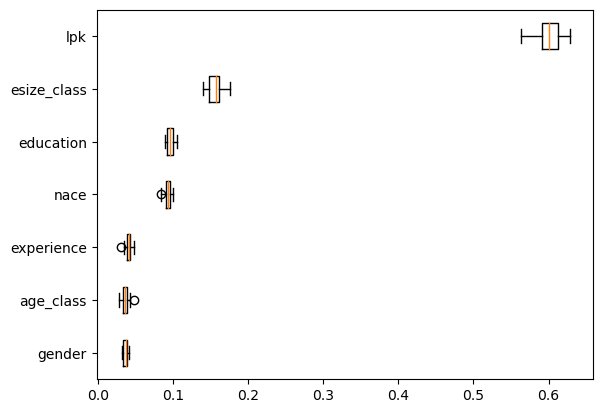

In [11]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_model, X_test, y_test,  n_repeats=30,  random_state=0)
importance_order = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
plt.boxplot(
    perm_importance.importances[importance_order].T,
    vert=False,
    labels=np.array(X_test.columns)[importance_order],
);

By far the most important feature is profession (lpk) followed by company size, education, economic sector and experience. Gender and age are less important.

# Model (Pipline) Serialization 

In [12]:
import joblib
joblib.dump(best_model, './Models/SVR_model.joblib')

['./Models/SVR_model.joblib']